Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию.

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности.

Постройте модель со значением метрики качества F1 не меньше 0.75.

**Инструкция по выполнению проекта**
1. Загрузите и подготовьте данные.
2. Обучите разные модели.
3. Сделайте выводы.

**Описание данных**

Данные находятся в файле toxic_comments.csv. Столбец text в нём содержит текст комментария, а toxic — целевой признак.

In [1]:
!pip install catboost
!pip install transformers


In [2]:
import numpy as np
import pandas as pd 
import IPython
from IPython.display import display
import re
import warnings
warnings.simplefilter('ignore')

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

from tqdm import notebook
import torch
import transformers

import nltk
nltk.download('wordnet')
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
nltk.download('stopwords')
from nltk.corpus import stopwords

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC, LinearSVC
from catboost import CatBoostClassifier

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
comments = pd.read_csv('toxic_comments.csv', index_col=0)
comments.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [4]:
comments.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.7+ MB


В представленном датасете 159571 строк и 2 столбца. Текст сырой, его необходимо будет очистить и ламметизировать. Пропущенных значений нет. Целевым признаком является ['toxic']-оценка токсичности в комментарии ['text']

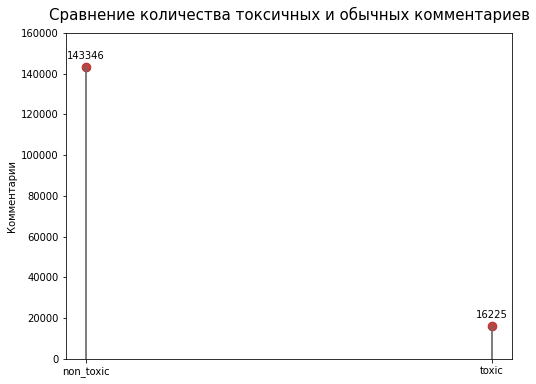

In [5]:
# Смотрю как распределен целевой признак
temp = pd.DataFrame(comments['toxic'].value_counts())
name = pd.Series(['non_toxic', 'toxic'], name='name')
temp = temp.join(name)

fig, ax = plt.subplots(figsize=(8,6))
ax.vlines(x=temp.name, ymin=0, ymax=temp['toxic'], color='dimgrey', alpha=0.85, linewidth=2)
ax.scatter(x=temp.name, y=temp['toxic'], s=75, color='firebrick', alpha=0.85)

for row in temp.itertuples():
    ax.text(row.Index, row.toxic+3000, s=row.toxic, 
            horizontalalignment= 'center', verticalalignment='bottom', fontsize=10)

ax.set_title('Сравнение количества токсичных и обычных комментариев', size=15, y=(1.02))
ax.set_ylabel('Комментарии')
ax.set_ylim(0, 160000)

plt.tight_layout
plt.show()


"Спокойных" комментариев ~ в 9 раз больше, чем токсичных. Классы несбалансированы.

Переходим к обработке текста.

**Токенизация и лемматизация**

Создаем корпус, разбиваем его на токены, проводим очистку, лемматизацию и создание tf-idf матриц.

In [6]:
text = comments['text'].values
text

array(["Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",
       "D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)",
       "Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",
       ...,
       'Spitzer \n\nUmm, theres no actual article for prostitution ring.  - Crunch Captain.',
       'And it looks like it was actually you who put on the speedy to have the first version deleted now that I look at it.',
       '"\nAnd ... I really don\'t think you understand.  I came here and my idea was bad right away.  What kind of communit

In [7]:
%%time
documents = []

stemmer = WordNetLemmatizer()

for sen in range(0, len(text)):
    # Удаляем все специальные символы
    document = re.sub(r'\W', ' ', str(text[sen]))
    
    # Удаляем единичные символы
    document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)
    
    # Удаляем единычные символы из начала строки
    document = re.sub(r'\^[a-zA-Z]\s+', ' ', document) 
    
    # Заменяем несколько пробелов на один
    document = re.sub(r'\s+', ' ', document, flags=re.I)
    
    # Удаляем 'b'
    document = re.sub(r'^b\s+', '', document)
    
    # Переводим заглавные буквы в строчные
    document = document.lower()
    
    # Лемматизация
    document = document.split()
    document = [stemmer.lemmatize(word) for word in document]
    document = ' '.join(document)
    
    documents.append(document)

CPU times: user 42.8 s, sys: 239 ms, total: 43 s
Wall time: 43 s


In [8]:
documents[:3]

['explanation why the edits made under my username hardcore metallica fan were reverted they weren vandalism just closure on some gas after voted at new york doll fac and please don remove the template from the talk page since m retired now 89 205 38 27',
 'd aww he match this background colour m seemingly stuck with thanks talk 21 51 january 11 2016 utc',
 'hey man m really not trying to edit war it just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page he seems to care more about the formatting than the actual info']

In [9]:
lemmas = pd.Series(documents, name='lemmas')
lemmas.head()

0    explanation why the edits made under my userna...
1    d aww he match this background colour m seemin...
2    hey man m really not trying to edit war it jus...
3    more can make any real suggestion on improveme...
4    you sir are my hero any chance you remember wh...
Name: lemmas, dtype: object

In [10]:
comments = pd.concat([comments, lemmas], axis=1)
comments

,text,toxic,lemmas
0,Explanation\nWhy the edits made under my usern...,0,explanation why the edits made under my userna...
1,D'aww! He matches this background colour I'm s...,0,d aww he match this background colour m seemin...
2,"Hey man, I'm really not trying to edit war. It...",0,hey man m really not trying to edit war it jus...
3,"""\nMore\nI can't make any real suggestions on ...",0,more can make any real suggestion on improveme...
4,"You, sir, are my hero. Any chance you remember...",0,you sir are my hero any chance you remember wh...
...,...,...,...
159566,""":::::And for the second time of asking, when ...",0,and for the second time of asking when your vi...
159567,You should be ashamed of yourself \n\nThat is ...,0,you should be ashamed of yourself that is horr...
159568,"Spitzer \n\nUmm, theres no actual article for ...",0,spitzer umm there no actual article for prosti...
159569,And it looks like it was actually you who put ...,0,and it look like it wa actually you who put on...


In [11]:
X = comments['lemmas']
y = comments['toxic']

*Устанавливаем единый random_state для всего проекта, разбиваем сет на подвыборки в пропорции 60/20/20.*

In [12]:
RND_ST = 42

In [13]:
X_train, X_sub, y_train, y_sub = train_test_split(X, y, test_size=0.4, random_state=RND_ST)
X_valid, X_test,  y_valid, y_test = train_test_split(X_sub, y_sub, test_size=0.5, random_state=RND_ST)

In [14]:
X_train.shape, X_valid.shape, X_test.shape

((95742,), (31914,), (31915,))

In [15]:
tfidfconverter = TfidfVectorizer(max_features=6000, 
                                 min_df=5, max_df=0.7, 
                                 stop_words=stopwords.words('english'))

tfidfconverter.fit(X_train)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=0.7, max_features=6000,
                min_df=5, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True,
                stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours',
                            'ourselves', 'you', "you're", "you've", "you'll",
                            "you'd", 'your', 'yours', 'yourself', 'yourselves',
                            'he', 'him', 'his', 'himself', 'she', "she's",
                            'her', 'hers', 'herself', 'it', "it's", 'its',
                            'itself', ...],
                strip_accents=None, sublinear_tf=False,
                token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
                vocabulary=None)

Конвертируем все выборки в матрицы.

In [16]:
X_train_tf = tfidfconverter.transform(X_train)
X_valid_tf = tfidfconverter.transform(X_valid)
X_test_tf = tfidfconverter.transform(X_test)

In [17]:
X_train_tf

<95742x6000 sparse matrix of type '<class 'numpy.float64'>'
	with 2284469 stored elements in Compressed Sparse Row format>

**Вывод**

На данном этапе произведен анализ данных и предобработка текста в читаемый моделями вид.

В исходном датасете содержаться ~160 тысяч комментариев, десятая часть которых являются токсичными. Пропусков не обнаружено.

Предобработка была произведена библиотекой nltk и трансформером TfidfVectorizer

На следующем шаге будет произведен тест работы моделей на подготовленных данных.

## Обучение и тестирование моделей

В тестировании будем использовать в основном линейные модели, как самые быстрые и удобные при работе с текстом.

Создадим таблицу, в которую будем вносить полученные значения метрики f1.

In [18]:
res = {
    'name_model':pd.Series(['LogReg','LinSVM','SGD']),
    'f1_val_nltk':pd.Series([]),
    'f1_val_bert':pd.Series([]),
    'f1_test_nltk':pd.Series([]),
    'f1_test_bert':pd.Series([]),
}
result = pd.DataFrame(res)
result

,name_model,f1_val_nltk,f1_val_bert,f1_test_nltk,f1_test_bert
0,LogReg,NaN,NaN,NaN,NaN
1,LinSVM,NaN,NaN,NaN,NaN
2,SGD,NaN,NaN,NaN,NaN


**Logistic Regression**

Как обычно, подбираем параметры через GridSearch.

In [19]:
def grid_search(model, params, features, target):
    
    search = GridSearchCV(model, params, verbose=1, cv=5, scoring='f1', n_jobs=-1)
    search.fit(features, target)
    
    print(search.best_score_)
    print(search.best_params_)

Создадим функицю, которая будет выводить f1-score и матрицу ошибок обученной модели на новых данный.

In [20]:
def model_report(fitted_model, feature, target):

    pred = fitted_model.predict(feature)
    conf_matrix = confusion_matrix(target, pred)
    
    print('f1_score = {:.3}'.format(f1_score(target, pred)))
    
    plt.figure(figsize=(4,4))
    sns.heatmap(conf_matrix,annot=True,cmap="Blues",fmt="d",cbar=False)
    plt.title('Confusion matrix');

Возвращаемся к логистической регрессии.

In [21]:
lr = LogisticRegression(random_state=RND_ST)

lr_params = dict(C = [0.1,1,10,100], 
                 tol = [1e-03, 1e-04, 1e-05])

In [22]:
grid_search(lr, lr_params, X_train_tf, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   34.3s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   47.6s finished


0.7605246575024063
{'C': 10, 'tol': 0.001}


In [23]:
lr_final = LogisticRegression(C=10, tol=0.0001)

lr_final.fit(X_train_tf, y_train);

Проверяем на трейне и смотрим, что на валидационной выборке.


In [24]:
f1_score(y_train, lr_final.predict(X_train_tf))

0.8236972775526511

f1_score = 0.765


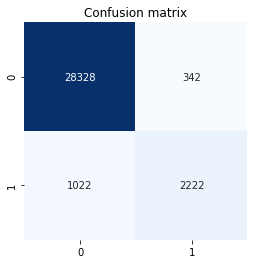

In [25]:
model_report(lr_final, X_valid_tf, y_valid)

"Проходной" балл на валидационном сете, однако, заметно достаточно большое количество ложно-положительных предсказаний модели.

In [26]:
result.loc[0, 'f1_val_nltk'] = 0.765

**Линейный опорный вектор**

In [27]:
svm = LinearSVC(random_state = RND_ST)

svm_params = dict(C=[0.1,1,10,100],
                  max_iter=[1000,2000])

In [28]:
svm_final = LinearSVC(C=1, max_iter=1000, random_state=RND_ST)

svm_final.fit(X_train_tf, y_train);

In [29]:
f1_score(y_train, svm_final.predict(X_train_tf))

0.8200403109703426

f1_score = 0.767


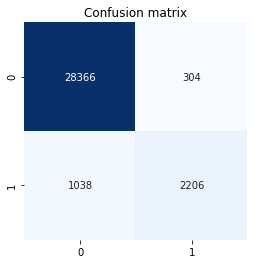

In [30]:
model_report(svm_final, X_valid_tf, y_valid)

Слегка улучшили количество ложно-отрицательных ответов, при этом, незначительно увеличелось количество ложно-положительных. На 1 сотую улучшилась общая метрика f1.

In [31]:
result.loc[1, 'f1_val_nltk'] = 0.767
result

,name_model,f1_val_nltk,f1_val_bert,f1_test_nltk,f1_test_bert
0,LogReg,0.765,NaN,NaN,NaN
1,LinSVM,0.767,NaN,NaN,NaN
2,SGD,NaN,NaN,NaN,NaN


**Stochastic Gradient Descent Classifier**

In [32]:
sgd = SGDClassifier(random_state=RND_ST)

sgd_params = dict(alpha=[1e-04, 1e-05, 1e-06],
                  penalty=['l1','l2'])

In [33]:
grid_search(sgd, sgd_params, X_train_tf, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    7.1s finished


0.7678489539887451
{'alpha': 1e-05, 'penalty': 'l1'}


In [34]:
sgd_final = SGDClassifier(alpha=1e-05, penalty='l1', random_state=RND_ST)

sgd_final.fit(X_train_tf, y_train);

In [35]:
f1_score(y_train, sgd_final.predict(X_train_tf))

0.7920826764757402

f1_score = 0.771


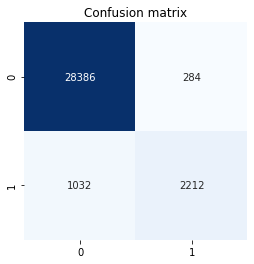

In [36]:
model_report(sgd_final, X_valid_tf, y_valid)

f1 удалось увеличить на 0,1 пункта за счет снижения ложно-отрицательных ответов и небольшого снижения ложно-положительных.

In [37]:
result.loc[2, 'f1_val_nltk'] = 0.771
result

,name_model,f1_val_nltk,f1_val_bert,f1_test_nltk,f1_test_bert
0,LogReg,0.765,NaN,NaN,NaN
1,LinSVM,0.767,NaN,NaN,NaN
2,SGD,0.771,NaN,NaN,NaN


## Тестирование моделей

f1_score = 0.766


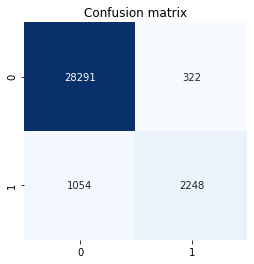

In [38]:
model_report(lr_final, X_test_tf, y_test)

In [39]:
result.loc[0, 'f1_test_nltk'] = 0.764

f1_score = 0.769


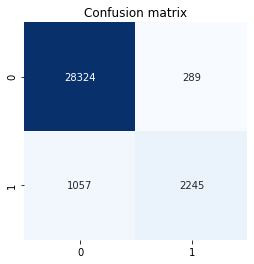

In [40]:
model_report(svm_final, X_test_tf, y_test)

In [41]:
result.loc[1, 'f1_test_nltk'] = 0.769

f1_score = 0.777


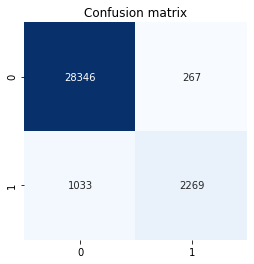

In [42]:
model_report(sgd_final, X_test_tf, y_test)

In [43]:
result.loc[2, 'f1_test_nltk'] = 0.791

In [44]:
result

,name_model,f1_val_nltk,f1_val_bert,f1_test_nltk,f1_test_bert
0,LogReg,0.765,NaN,0.764,NaN
1,LinSVM,0.767,NaN,0.769,NaN
2,SGD,0.771,NaN,0.791,NaN


In [46]:
temp = result[['name_model','f1_test_nltk']].sort_values(by='f1_test_nltk')

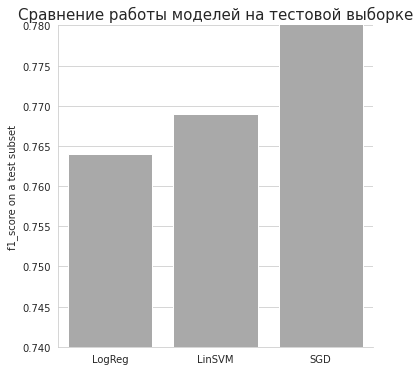

In [47]:
sns.set_style('whitegrid')

sns.catplot(x='name_model', y='f1_test_nltk', data=temp, kind="bar", color='darkgrey')
plt.xlabel('')
plt.ylabel('f1_score on a test subset')
plt.ylim(0.74,0.78)
plt.title('Сравнение работы моделей на тестовой выборке', size=15);

Из результатов исследования можно заключить, что модель SGD продемонстрировала лучший результат, преодолев отметку f1 = 0,777 на тестовой выборке. Это средний результат, однако он подходит под нижний предел задания.

Необходимо только разобраться с БЕРТОМ, уверен, что лучшая предобработка данных позволить получить лучшие показатели.

## Вывод
На втором этапе исследования происходило сравнение работы моделей на предобработанных данных. Основной стак составляли линейные модели, обладающие высокой скоростью работы и достаточно высокой степенью качества прогноза. Дополнительно был протестирован градиентный ансамбль catboost.
Лучший показатель f1 принадлежит модели SGDClassifier: 0,771 и 0,777 на проверочной и тестовой выборках, соотвественно.

## Общий вывод
В первом работе по работе с текстом перед нами стояла задача создать модель, способную отличать токсичные комментарии от обычных, и делать это с показателем метрики f1 >= 0.75.

На первом этапе было произведено знакомство с даннымы, указано отсутсвие пропусков и выявлена общая информация о датасете.
Далее последовала предобработка с лемматизацией, удалением ненужных символов и переводом комментариев в матрицы tf-idf.

На втором шаге были протестированы 4 модели - три представителя линейных классификаторов и ансамбль градиентного спуска. На тестовой выборке все модели показали допустимый результат. Лучший показатель у SGDClassifier - 0.79 на тестовой выборке.

Несмотря на "проходимость" результата, продолжаю искать новые пути и методы для улучшения качества предсказания.